<a href="https://colab.research.google.com/github/teamgaon/KIST/blob/main/220426_KIST_deeplabv3_resnet50_linear_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import albumentations
import albumentations.pytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
import albumentations as A
from sklearn.model_selection import KFold, StratifiedKFold
from datetime import datetime, timedelta
import random
import torchvision.transforms as transforms
import gc
from PIL import Image

In [3]:
train_cases = glob('/content/drive/MyDrive/KIST/open/train/*')
train_cases.sort()

CASE01_01.png
leaf_weight : 49.193


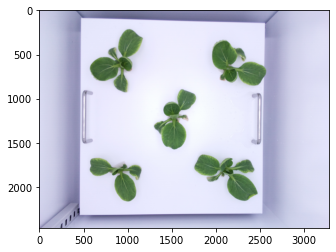

CASE01_02.png
leaf_weight : 59.764


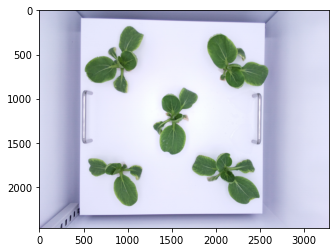

CASE01_03.png
leaf_weight : 72.209


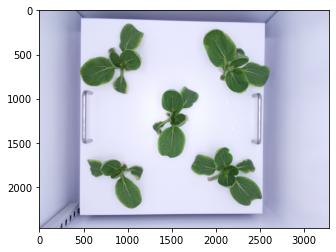

CASE01_04.png
leaf_weight : 85.737


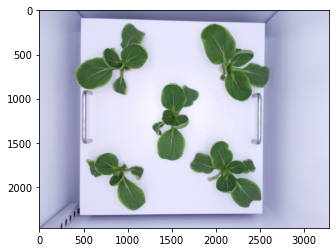

CASE01_05.png
leaf_weight : 102.537


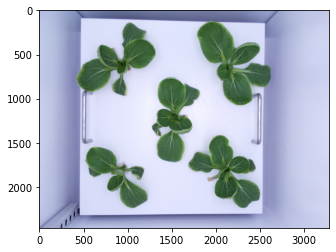

CASE01_06.png
leaf_weight : 123.359


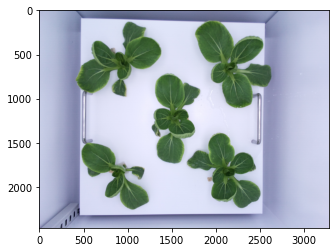

CASE01_07.png
leaf_weight : 156.149


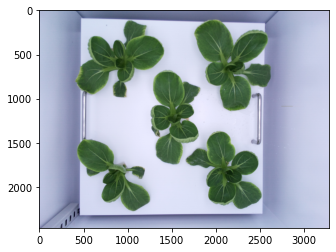

CASE01_08.png
leaf_weight : 174.931


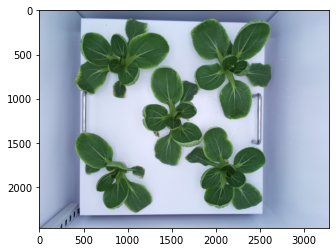

CASE01_09.png
leaf_weight : 187.523


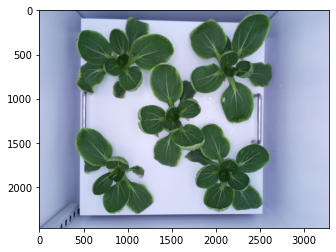

In [4]:
images = glob(train_cases[0]+'/image/*')
images.sort()
label = pd.read_csv(train_cases[0]+'/label.csv')
for i in range(len(images)):
  image = cv2.imread(images[i])
  print(images[i][-13:])
  print('leaf_weight : ' + str(label['leaf_weight'].loc[i]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

CASE02_01.png
leaf_weight : 194.662


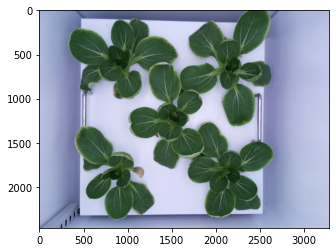

CASE02_02.png
leaf_weight : 198.366


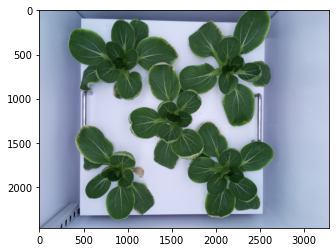

CASE02_03.png
leaf_weight : 196.788


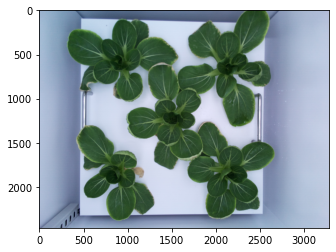

CASE02_04.png
leaf_weight : 197.342


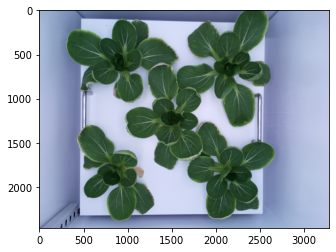

CASE02_05.png
leaf_weight : 200.202


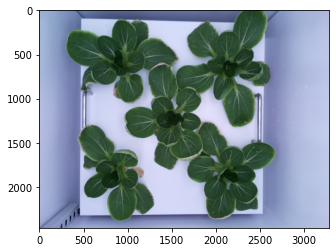

CASE02_06.png
leaf_weight : 201.48


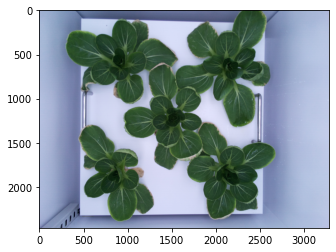

CASE02_07.png
leaf_weight : 197.409


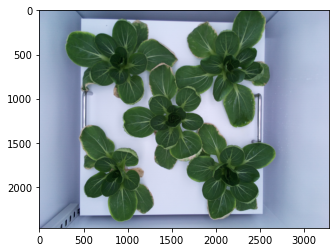

CASE02_08.png
leaf_weight : 185.996


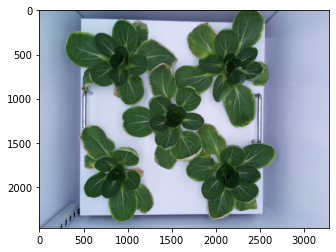

CASE02_09.png
leaf_weight : 165.73


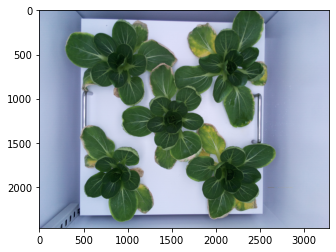

CASE02_10.png
leaf_weight : 153.971


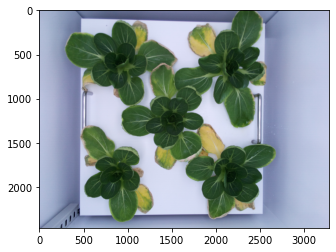

CASE02_11.png
leaf_weight : 142.744


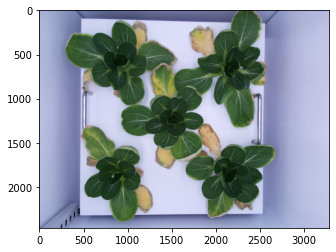

In [5]:
images = glob(train_cases[1]+'/image/*')
images.sort()
label = pd.read_csv(train_cases[1]+'/label.csv')
for i in range(len(images)):
  image = cv2.imread(images[i])
  print(images[i][-13:])
  print('leaf_weight : ' + str(label['leaf_weight'].loc[i]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

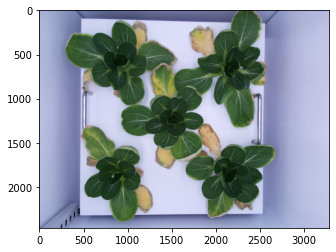

In [6]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

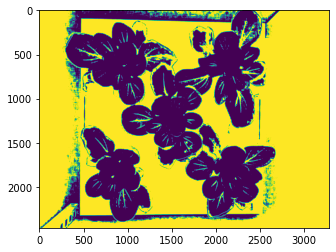

In [7]:
hsvlower = np.array([0, 20, 00])
hsvupper = np.array([360, 80, 255])
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
hsv_mask = cv2.inRange(hsv, hsvlower, hsvupper)
plt.imshow(hsv_mask)
plt.show()

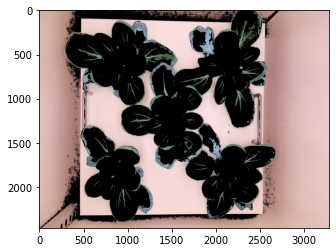

In [8]:
result = cv2.bitwise_and(image, image, mask=hsv_mask)
plt.imshow(result)
plt.show()

CASE03_01.png
leaf_weight : 11.337


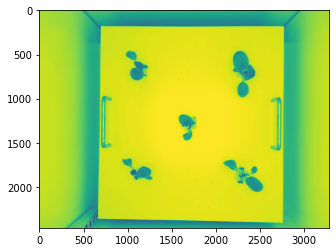

CASE03_02.png
leaf_weight : 15.728


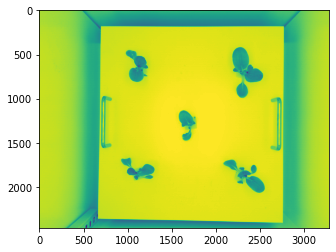

CASE03_03.png
leaf_weight : 21.492


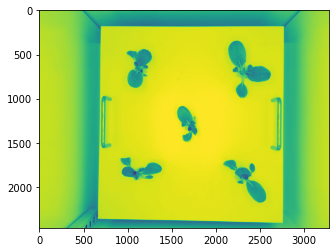

CASE03_04.png
leaf_weight : 27.091


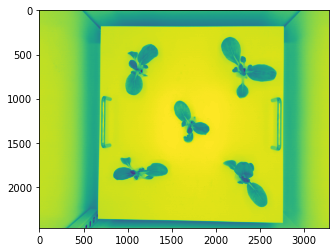

CASE03_05.png
leaf_weight : 32.278


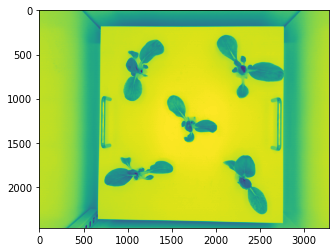

In [9]:
images = glob(train_cases[2]+'/image/*')
images.sort()
label = pd.read_csv(train_cases[2]+'/label.csv')
for i in range(len(images)):
  image = cv2.imread(images[i])
  print(images[i][-13:])
  print('leaf_weight : ' + str(label['leaf_weight'].loc[i]))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  plt.imshow(image)
  plt.show()

In [10]:
image

array([[220, 219, 220, ..., 225, 219, 216],
       [221, 220, 219, ..., 224, 219, 219],
       [223, 224, 222, ..., 224, 223, 220],
       ...,
       [220, 219, 217, ..., 226, 228, 227],
       [220, 219, 217, ..., 225, 223, 224],
       [221, 219, 217, ..., 224, 223, 224]], dtype=uint8)

In [11]:
test_images = glob('/content/drive/MyDrive/KIST/open/test/image/*')
test_images.sort()
test_metas = glob('/content/drive/MyDrive/KIST/open/test/meta/*')
test_metas.sort()

image/001.png


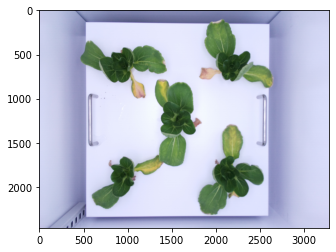

image/002.png


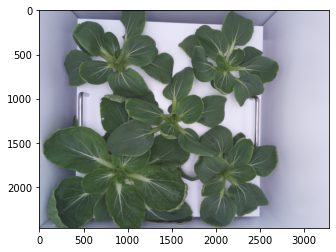

image/003.png


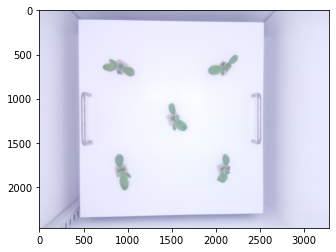

image/004.png


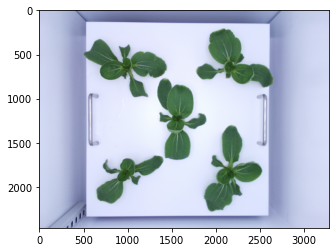

image/005.png


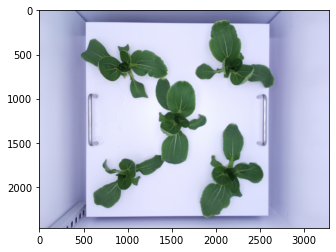

image/006.png


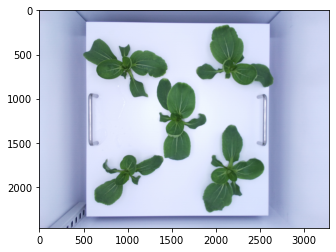

image/007.png


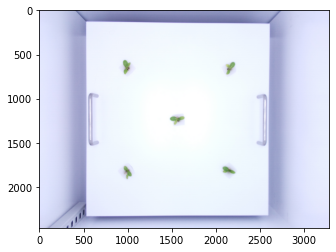

image/008.png


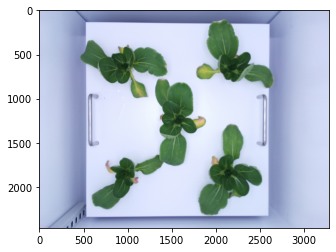

image/009.png


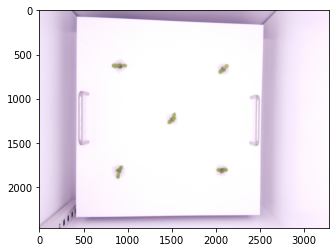

image/010.png


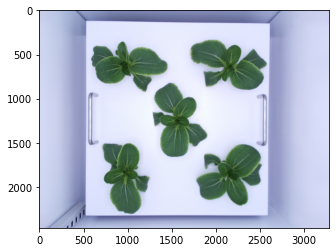

In [12]:
for i in range(10):
  meta = test_metas[i]
  image = cv2.imread(test_images[i])
  print(test_images[i][-13:])
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

In [90]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

CASE01_01.png
leaf_weight : 49.193


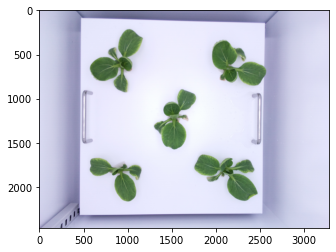

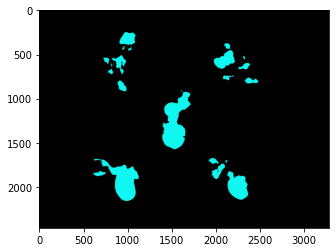

CASE01_02.png
leaf_weight : 59.764


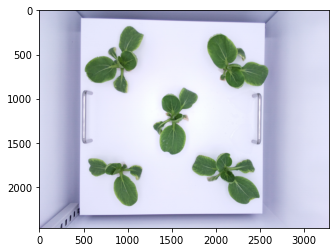

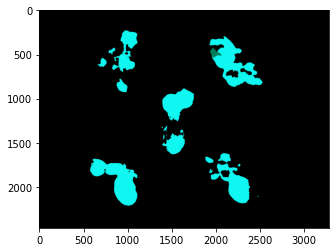

CASE01_03.png
leaf_weight : 72.209


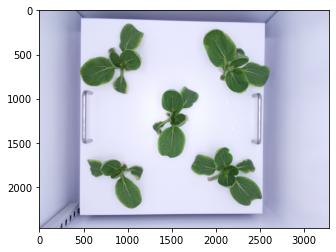

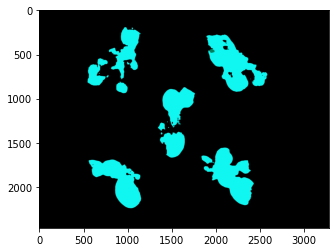

CASE01_04.png
leaf_weight : 85.737


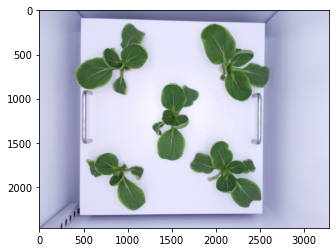

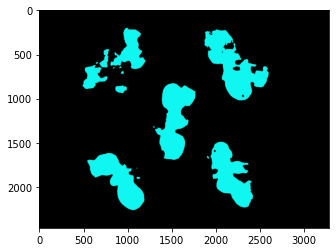

CASE01_05.png
leaf_weight : 102.537


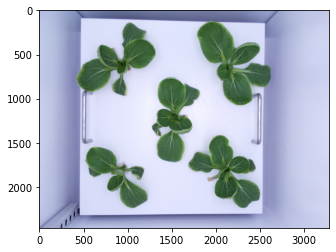

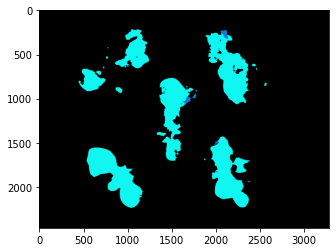

CASE01_06.png
leaf_weight : 123.359


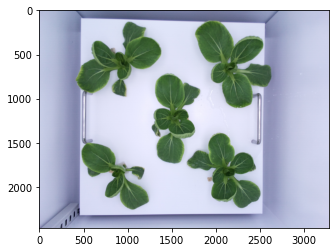

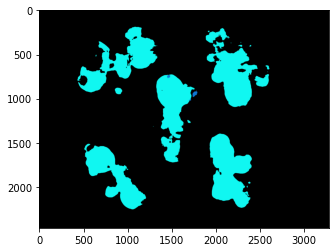

CASE01_07.png
leaf_weight : 156.149


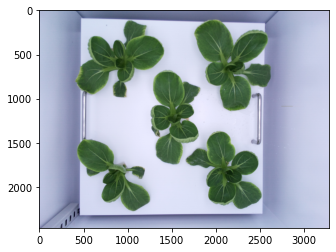

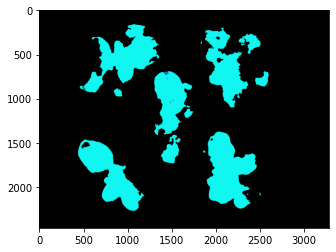

CASE01_08.png
leaf_weight : 174.931


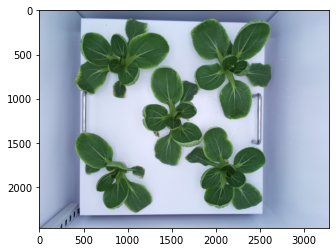

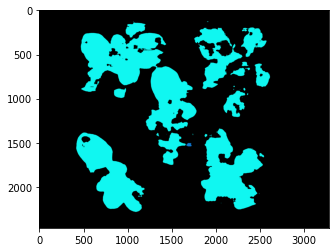

CASE01_09.png
leaf_weight : 187.523


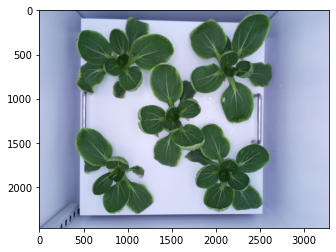

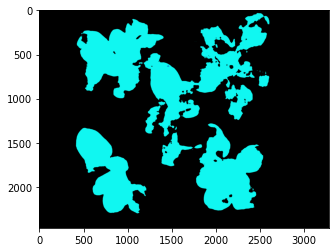

In [17]:
images = glob(train_cases[0]+'/image/*')
images.sort()
label = pd.read_csv(train_cases[0]+'/label.csv')
for i in range(len(images)):
  input_image = Image.open(images[i])
  origin_image = cv2.imread(images[i])
  input_image = input_image.convert("RGB")

  print(images[i][-13:])
  print('leaf_weight : ' + str(label['leaf_weight'].loc[i]))

  plt.imshow(cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB))
  plt.show()

  preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)

  if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

  with torch.no_grad():
    output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
  colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
  colors = (colors % 255).numpy().astype("uint8")

  # plot the semantic segmentation predictions of 21 classes in each color
  r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
  r.putpalette(colors)

  plt.imshow(r)
  plt.show()

In [51]:
my_area = []
my_weights = []

for j in tqdm(range(len(train_cases))):
  images = glob(train_cases[j]+'/image/*')
  images.sort()
  label = pd.read_csv(train_cases[j]+'/label.csv')
  for i in range(len(images)):
    input_image = Image.open(images[i])
    # origin_image = cv2.imread(images[i])
    input_image = input_image.convert("RGB")

    # print(images[i][-13:])
    # print('leaf_weight : ' + str(label['leaf_weight'].loc[i]))
    my_weights.append(label['leaf_weight'].loc[i])

    # plt.imshow(cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB))
    # plt.show()
    # 이거 밖으로 빼기
    preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    # 이거도 밖으로 빼기
    if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

    with torch.no_grad():
      output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)

    # palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    # colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    # colors = (colors % 255).numpy().astype("uint8")

    # # plot the semantic segmentation predictions of 21 classes in each color
    # r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
    # r.putpalette(colors)

    # plt.imshow(r)
    # plt.show()
    my_area.append(len(np.where(output_predictions.cpu().numpy()>0)[0])/(len(output_predictions.cpu().numpy())*len(output_predictions.cpu().numpy()[0])))
    # print(len(np.where(output_predictions.cpu().numpy()>0)[0])/(len(output_predictions.cpu().numpy())*len(output_predictions.cpu().numpy()[0])))

100%|██████████| 75/75 [1:12:24<00:00, 57.92s/it]


In [53]:
len(my_area)

1592

In [54]:
len(my_weights)

1592

In [55]:
df = pd.DataFrame({'area':my_area, 'weight':my_weights})
df.head()

area   weight
0  0.047064   49.193
1  0.072683   59.764
2  0.104121   72.209
3  0.123922   85.737
4  0.111444  102.537

In [56]:
df.to_csv('/content/drive/MyDrive/KIST/df.csv', index=False)

In [81]:
from sklearn.model_selection import train_test_split
X = df['area']
y = df['weight']
# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

In [82]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(X.values.reshape(-1, 1), y)
# y_pred = model.predict(X_test.values.reshape(-1, 1))

LinearRegression()

In [83]:
LR_model.score(X.values.reshape(-1, 1), y)

0.7073063067755491

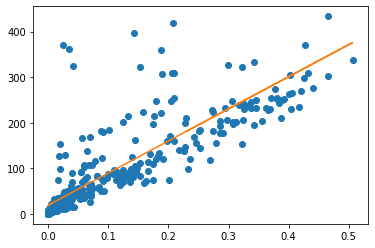

In [73]:
# plt.plot(X_test, y_test, 'o')
# plt.plot(X_test, y_pred.reshape(-1,1))
# plt.show()

In [74]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred)/np.mean(y_test))

0.3715895719532311


In [ ]:
test_images = glob('/content/drive/MyDrive/KIST/open/test/image/*')
test_images.sort()
preprocess = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

my_area = []
for i in tqdm(range(len(test_images))):
  input_image = Image.open(test_images[i])
  input_image = input_image.convert("RGB")
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)

  if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

  with torch.no_grad():
    output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)
  my_area.append(len(np.where(output_predictions.cpu().numpy()>0)[0])/(len(output_predictions.cpu().numpy())*len(output_predictions.cpu().numpy()[0])))
  # print(len(np.where(output_predictions.cpu().numpy()>0)[0])/(len(output_predictions.cpu().numpy())*len(output_predictions.cpu().numpy()[0])))

 28%|██▊       | 128/460 [04:09<10:47,  1.95s/it]

In [ ]:
y_pred = LR_model.predict(my_area.values.reshape(-1, 1))

In [50]:
pd.read_csv('/content/drive/MyDrive/KIST/open/sample_submission.csv')

img_name  leaf_weight
0    001.png            0
1    002.png            0
2    003.png            0
3    004.png            0
4    005.png            0
..       ...          ...
455  456.png            0
456  457.png            0
457  458.png            0
458  459.png            0
459  460.png            0

[460 rows x 2 columns]